In [1]:
import torch
from torch import tensor, autograd, nn, optim
from torchvision.transforms import functional, transforms
from torch.utils.data import TensorDataset, DataLoader

import glob
import tqdm
import time
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# アンビグラムをGANで生成
反転や回転などの変換をしても何らかの文字に見えるような文字をアンビグラムと言います。<br>
データセットはNDLラボで公開されているものを利用しました<br>
https://lab.ndl.go.jp/cms/kanji300 <br>
からダウンロードできます
## モデル
・z_dim : 入力となるランダムな値の次元数<br>
・image_size : 判定に用いる真の画像のサイズ。今回は文字の生成なので48×48の1チャネル画像を用いている<br>
nn.ConvTranspose2dはいわゆるでコンボリューションを行っており、一般のコンボリューションとは逆に画像のサイズを拡大している。
これは、入力された画像の各画素の値をフィルターにかけ、その結果をずらて足し合わせたものを出力することで実現している。<br>

In [2]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size = 48):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8,kernel_size=3,stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4,
                              kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2,
                              kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size,
                              kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
    def forward(self,z):
        x = self.layer1(z)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.last(x)
        return x


class Discriminator(nn.Module):
    def __init__(self,image_size=48):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        self.last = nn.Sequential(
            nn.Linear(image_size*8*3*3,1),
            nn.Sigmoid())
    def forward(self,z):
        x = self.layer1(z)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.last(x)
        return x
    def num_flat_features(self,x):
        #Conv2dは入力を4階のテンソルとして保持する(サンプル数*チャネル数*縦の長さ*横の長さ)
        #よって、特徴量の数を数える時は[1:]でスライスしたものを用いる
        size=x.size()[1:]
        #特徴量の数=チャネル数*縦の長さ*横の長さを計算する
        num_features=1
        for s in size:
            num_features *= s
        return num_features

## 前処理、データのロード

In [3]:
class ImageTransform():
    def __init__(self,mean,std):
        self.data_transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    def __call__(self,img,rotate=False):
        if not rotate:
            img = functional.rotate(img,180)
        return self.data_transform(img)

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, file_path1, file_path2, transform):
        #file_path1が変換を行わない画像. pathlib.Pathで入力する必要がある
        #file_path2が180度回転した画像. pathlib.Pathで入力する必要がある
        self.transform = transform
        self.file_list1 = list((file_path1).glob("*.png"))
        self.file_list2 = list((file_path2).glob("*.png"))
        self.file_list = self.file_list1 + self.file_list2
        self.rotate = [False]*len(self.file_list1) + [True]*len(self.file_list2)
    def __len__(self):
        return len(self.file_list1 + self.file_list2)
    def __getitem__(self,index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img,rotate = self.rotate[index])
        return img_transformed

## 学習
### 学習の関数を作成

In [4]:
def weight_init(m):
    #ネットワークの初期化
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #Conv2dとConvTransposed2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        #BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def train_model(G, D, dataloader, num_epochs, batch_size = 10):
    z_dim = 20
    #モデルを学習させる関数
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス ：",device)
    #最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])
    #誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    G.to(device)
    D.to(device)
    G.train()
    D.train()
    #ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    #イテレーションカウンタをセット
    iteration = 1
    logs = []
    
    for epoch in range(num_epochs):
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        print('--------------------------------------------------------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print(' (train) ')
        #データローダーからminibatchずつ取りだすループ
        for i,imges in tqdm.tqdm(enumerate(dataloader),total=len(dataloader)):
            #----------------------
            #1. Discriminatorの学習
            #----------------------
            if imges.size()[0] == 1:
                #ミニバッチがサイズが1だとバッチノーマライゼーションでエラーになるので避ける
                continue
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,),1).to(device)
            label_fake = torch.full((mini_batch_size,),0).to(device)
            
            d_out_real = D(imges)
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_imges = G(input_z)
            d_out_fake = D(fake_imges)
            
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            
            #----------------------
            #2. Generatorの学習
            #----------------------
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0),input_z.size(1),1,1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            g_loss = criterion(d_out_fake.view(-1),label_real)
            
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()
            
            #----------------------
            #3. 記録
            #----------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer: {:.4f}sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time
    return G,D

### 学習

In [32]:
list(path1.glob("*"))

[PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1933_1190560_0071.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1943_1069740_0055.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1907_832892_0091.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1943_1711955_0070.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1927_1091138_0019.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1942_1123185_0020.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1920_958143_0012.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1906_792159_0145.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5/1916_986069_0149.png'),
 PosixPath('/Applications/iCollections/focusing topic/ambigram/kanji300/U4EE5

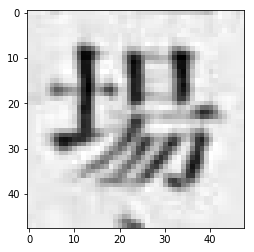

In [36]:
path_list = list((p/"kanji300").glob("U*"))
path1 = path_list[12]
path2 = path_list[11]
img1 = Image.open(list(path1.glob("*"))[0])
img2 = Image.open(list(path2.glob("*"))[0])
plt.imshow(img2)

In [5]:
G = Generator()
D = Discriminator()
G.apply(weight_init)
D.apply(weight_init)
p = Path.cwd()
mean,std = (0.5,), (0.5,)
data_set = ImageDataset(file_path1=path1,file_path2=path2, transform=ImageTransform(mean,std))
dataloader = torch.utils.data.DataLoader(data_set, batch_size=4, shuffle=True)
G,D = train_model(G,D,dataloader, num_epochs = 3, batch_size = 1)

  0%|          | 0/403 [00:00<?, ?it/s]

使用デバイス ： cpu
--------------------------------------------------------------
Epoch 0/3
-------------
 (train) 


  0%|          | 0/403 [00:00<?, ?it/s]

-------------
epoch 0 || Epoch_D_Loss:119.6500 ||Epoch_G_Loss:65.7979
timer: 100.6894sec.
--------------------------------------------------------------
Epoch 1/3
-------------
 (train) 


  0%|          | 0/403 [00:00<?, ?it/s]

-------------
epoch 1 || Epoch_D_Loss:110.5500 ||Epoch_G_Loss:68.7746
timer: 99.6768sec.
--------------------------------------------------------------
Epoch 2/3
-------------
 (train) 


100%|██████████| 403/403 [01:40<00:00,  4.01it/s]

-------------
epoch 2 || Epoch_D_Loss:111.0664 ||Epoch_G_Loss:66.4960
timer: 100.8410sec.


## 画像の生成

In [23]:
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0),fixed_z.size(1),1,1)

fake_images = G(fixed_z)

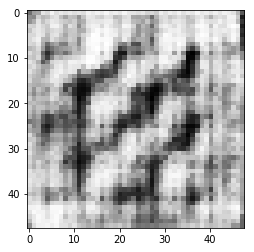

In [26]:
plt.imshow(fake_images[1][0].cpu().detach().numpy(), 'gray')